# Example - Real Electronics Data

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch

sys.path.append('../src')
from deepymod_torch.library_function import mech_library_real
from deepymod_torch.DeepMod import DeepMoD
import deepymod_torch.VE_params as VE_params

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
general_path = 'Oscilloscope data CRI electronics analogy/'
specific_path = 'AWG 7V full sinc 2 cap shunt/' # It is precisely here that changes the data we are grabbing to test.
path = general_path + specific_path

channel_1_data = np.loadtxt(path+'Channel 1 total voltage.csv', delimiter=',', skiprows=3)
channel_2_data = np.loadtxt(path+'Channel 2 voltage shunt resistor.csv', delimiter=',', skiprows=3)

The data contains a 'dead' period at the beginning before the voltage manipulation began, and then restarts the manipulation later on. We do not need to keep this data as it provides very little new information and makes the data significantly harder to fit. Below, by plotting the voltage data and tweaking the start and end points, we can isolate the interesting data.

In [3]:
#plt.plot(channel_1_data[899:3401, 1])

In [4]:
# lower = 899
# upper = 3401

# voltage = channel_1_data[lower:upper, 1]
# voltage_r1 = channel_2_data[lower:upper, 1]
# time = channel_1_data[lower:upper, 0]

In [5]:
voltage = channel_1_data[:, 1]
voltage_shunt = channel_2_data[:, 1]
time = channel_1_data[:, 0]

Here, I recover the current from the voltages measured.

The below has a big measurement oversight is that to get current from these voltages, I need to assume or already know all of my resistances.

In [6]:
r_0 = 1.995e3
r_1 = 1.999e3
r_2 = 1.995e3

# current_0 = voltage/r_0
# current_1 = voltage_r1/r_1
# current = current_0 + current_1

In [7]:
r_shunt = 10.8 # measured using multimeter

current = voltage_shunt/r_shunt

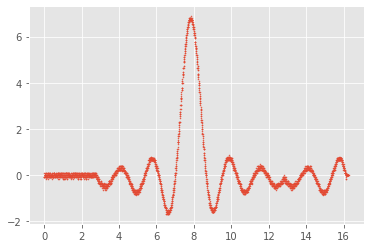

In [8]:
plt.plot(time, voltage, label='voltage', linestyle='None', marker='.', markersize=1)

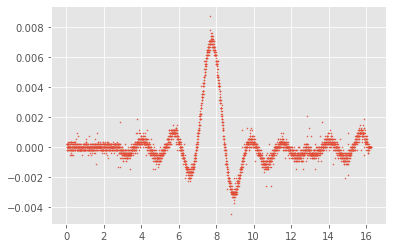

In [9]:
plt.plot(time, current, label='current', linestyle='None', marker='.', markersize=1)

## Data Treatment

In [10]:
# random seeding
np.random.seed(0)
torch.manual_seed(0)

In [11]:
# reshaping
time_array = time.reshape(-1, 1)
voltage_array = voltage.reshape(-1, 1)
current_array = current.reshape(-1, 1)

# 'normalising'
V_sf = 0.1
I_sf = 100
scaled_voltage = voltage_array*V_sf
scaled_current = current_array*I_sf

# structuring
target_array = np.concatenate((scaled_voltage, scaled_current), axis=1)

In [12]:
# random sampling
number_of_samples = 1000

reordered_row_indices = np.random.permutation(time_array.size)
reduced_time_array = time_array[reordered_row_indices, :][:number_of_samples]
reduced_target_array = target_array[reordered_row_indices, :][:number_of_samples]

## Predicting coefficients

First of all, we can forget that our problem has scaled data and do two things. First, remember that while capacitance is equivalent to viscosity, reistance is equivalent to the reciprocal of the elastic modulus. Second, we can put these viscosities and resistances into the function for calculating the expected coefficients. Intuitively for once, we interpret the model params as desribing a maxwell model. We do this because it was a Maxwell type model that we constructed on the breadboard, and so the parameters must be combined in a maxwell type fashion to return the equation coefficients.

In [13]:
equiv_E = [1/r_0, 1/r_1, 1/r_2]
equiv_eta = [1e-3, 220e-6]

pre_scaled_coeff_guess = VE_params.coeffs_from_model_params_maxwell(equiv_E, equiv_eta)
pre_scaled_coeff_guess

[0.205262941828482,
 0.539908801674946,
 409.499568947822,
 998.318999137895,
 359.278992261587]

Thanks to our scaling, the coefficients we are going to discover here are actually also scaled compared to the coefficients as they would have been if no scaling had taken place. This is because we have two dependant quantities that have been scaled differently. If it had been just one scale factor, the coefficients would have been the same.

The LHS of the equation, the first time derivative of voltage, has been scaled the same way as any other voltage term. As a result, the coefficient(s) for voltage term(s) will already be scaled correctly.  This is because, although the voltage seen by DeepMoD is 10x lower than in reality, this would only need to be balanced by a coeffient 10x higher if the total of the RHS (the LHS) hadn't also been made 10x lower. As the coeffient of the LHS is always one, and the time derivative is now 10x smaller, all terms on the RHS should also be 10x smaller than before. A coefficient on the voltage term remaining that is also 10x smaller is unnecessary, as the voltage is already 10x smaller.

However, for the current terms, they will all be 100x bigger, due to scaling, so the coeffients must be 1000x smaller than an unscaled set of coeffs to preserve each coeff\*term product as being 10x smaller than before scaling, to match the LHS.

In summary, we need to take the current coeffients and divide them by 1000 to predict the coeffients as they will be for the normalised data.

The formula for scaling each cofficient is thus:

$$
c_n = C_n\frac{\alpha_{LHS}}{\alpha_n}
$$

where $C_n$ is the true coeffient for the nth term, $c_n$ is the scaled version that DeepMoD will find, $\alpha_n$ is the scale factor that was applied to the dependant quantity in term n, and $\alpha_{LHS}$ is the scale factor that was applied to the dependant quantity put on the LHS. 

From this we see that the voltage terms on the RHS have no scaling as $\alpha_n = \alpha_{LHS}$

In [14]:
I_coeff_sf = V_sf/I_sf

terms = len(pre_scaled_coeff_guess)

post_scaled_coeff_guess = pre_scaled_coeff_guess.copy()
for idx in range(terms//2, terms):
    post_scaled_coeff_guess[idx] *= I_coeff_sf

post_scaled_coeff_guess

[0.205262941828482,
 0.539908801674946,
 0.409499568947822,
 0.998318999137895,
 0.359278992261587]

## DeepMod prep

Transform into tensors for use by pytorch

In [15]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)

Have a small period at start to train MSE only. Rational is to trian the MSE a bit, not so much as to fit the noise, but enough to try and guide the first several epochs of the main optimisation process in the right direction. The main optimisaton procedure will seemingly ruin most of the MSE only fit as it warps the data to fit, at this point, nonsense equation, but the hope is that it will briefly nudge the equation in the right direction.

In [16]:
optim_config = {'lambda': 0, 'max_iterations': 100001, 'mse_only_iterations': 20001, 'final_run_iterations': 10001}

output_dim is 2! This is because the NN is goign to learn to predict both V and I from t.

In [17]:
network_config = {'input_dim': 1, 'hidden_dim': 30, 'layers': 4, 'output_dim': 2}

new library function, simpler even than for synthetic data as no analytical differentiation occurs and voltage (or strain) is always assumed to be the first column of prediction and target. No need for input type or torch lambda entry in dictionary.

In [18]:
lib_config = {'type': mech_library_real, 'diff_order': 2, 'coeff_sign': 'positive'}

## Running DeepMoD

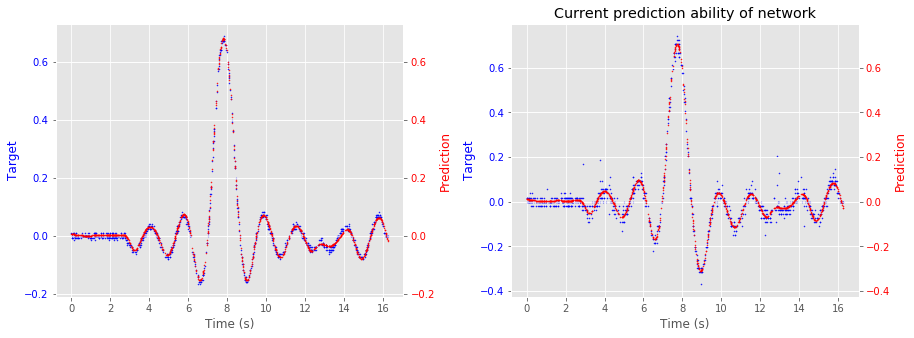

Epoch | Total loss | MSE | PI | L1 
20000 7.0E-04 6.9E-04 6.6E-06 0.0E+00
tensor([[0.2773],
        [0.3982],
        [0.5387],
        [1.0008],
        [0.3098]], requires_grad=True)
lrs are 0.001 0.004
Time elapsed: 23.0 minutes 39.469757080078125 seconds


In [ ]:
sparse_coeff_vector_list_list, scaled_coeff_vector_list_list, sparsity_mask_list_list, network = DeepMoD(time_tensor, target_tensor, network_config, lib_config, optim_config, plot=True)

### Results

In [ ]:
sparse_coeff_vector_list_list

In [ ]:
scaled_coeff_vector_list_list

In [ ]:
sparsity_mask_list_list

## Rediscovering model parameters

We need to take the coefficients that DeepMoD has found and reverse the process in predicting coeffients.

First we do the reverse scaling of the coeffs, this time dividing by the multiplication factor previously found, to scale the scaled coefficients to the true ones.

In [ ]:
result = sparse_coeff_vector_list_list[-1][0].clone().detach()
terms = len(result)

for idx in range(terms//2, terms):
    result[idx] /= I_coeff_sf

result

We next use these coefficients to recover our model parameters.

In [ ]:
visco_params = VE_params.model_params_from_coeffs_maxwell(result)
visco_params

Lastly, these parameters correspond to viscosities and elastic moduli, not capacitances and resistances. They actually do correspond to the capacitance and conductivity, but if we want resistance, we must take the reciprocal of all the 'elastic moduli' terms.

In [ ]:
elec_params = list(visco_params[0][0])
for idx in range(terms//2 + 1):
    elec_params[idx] = 1/elec_params[idx]

elec_params